<a href="https://colab.research.google.com/github/npgeorge/DS-Unit-2-Applied-Modeling/blob/master/NHL_Data_Project_Team_Stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Answers

Choose your target. Which column in your tabular dataset will you predict?

I will predict on the "outcome" column for the Boston Bruins first, and apply that model to all teams.

Is your problem regression or classification?

Regression, win or loss is binary. I could try classification as well. 

How is your target distributed?

Regression: Is the target right-skewed? If so, you may want to log transform the target. TBD. 


Choose which observations you will use to train, validate, and test your model.

    - Are some observations outliers? Will you exclude them? TBD
    - Will you do a random split or a time-based split? Random. 


Choose your evaluation metric(s).
    - Classification: Is your majority class frequency > 50% and < 70% ? If so, you can just use accuracy if you want. Outside that range, accuracy could be misleading. What evaluation metric will you choose, in addition to or instead of accuracy?
- Begin to clean and explore your data.
- Begin to choose which features, if any, to exclude. Would some features "leak" future information?

In [0]:
#use first principles to figure out end data frame
#what are the foundational differences, keep it small, build from there.

#due to the many data frames, my goal is to build one comprehensive data frame
#this one data frame will be used to try to predict who will win each game.

#target
#'outcome' column from the game csv

#regression
#win, loss, or tie will numerically represented

#target distribution
#need to explore

#I will train/test/val on each season separately.
#If this doesn't work, I will try multiple seasons at a time. 
#Perhaps a 'returning_players' parameter giving a % of how many players stay YoY could be useful



In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [0]:
# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
#Step 2 to authenticate
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#2.1 Get the file id from shareable link in drive
downloaded = drive.CreateFile({'id':'1djfcENPCc0lXD088bVQnkxwpXFHDnfHi'}) # replace the id with id of file you want to access
downloaded.GetContentFile('game_teams_stats.csv')
df = pd.read_csv('game_teams_stats.csv') 

In [20]:
df.head()

,game_id,team_id,HoA,won,settled_in,head_coach,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways
0,2011030221,1,away,False,OT,Peter DeBoer,3,26,31,12,3,1,44.9,6,7
1,2011030221,4,home,True,OT,Peter Laviolette,4,36,27,6,6,1,55.1,13,4
2,2011030222,1,away,True,REG,Peter DeBoer,4,35,32,12,4,0,50.9,8,7
3,2011030222,4,home,False,REG,Peter Laviolette,1,20,24,32,5,0,49.1,9,6
4,2011030223,4,away,False,OT,Peter Laviolette,3,28,28,4,5,1,50.8,2,1


In [21]:
#bruins
#if a model works for one team, it *could* work broadly for others
#this may turn out to be a bad assumption
#this filter returns the df for the Bruins
#or statement for home and away games

bruins_id_condition = df['team_id'] == 6 #(df['home_team_id'] == 6) | (df['away_team_id'] == 6)
df_bruins = df[bruins_id_condition]
df_bruins.shape

(812, 15)

In [22]:
#baseline, can we beat the Bruins baseline target?
baseline_target = 'won'
y_baseline = df_bruins[baseline_target]
y_baseline.value_counts(normalize=True) 

True     0.57266
False    0.42734
Name: won, dtype: float64

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
#train, test
train, test = train_test_split(df_bruins, 
                               train_size=0.80, 
                               test_size=0.20,
                               stratify=df_bruins['won'], 
                               random_state=42)
train.shape, test.shape

((649, 15), (163, 15))

In [24]:
#train, val
train, val = train_test_split(train, 
                              train_size=0.80, 
                              test_size=0.20, 
                              stratify=train['won'], 
                              random_state=42)
train.shape, val.shape

((519, 15), (130, 15))

In [0]:
#target and features
target = 'won'
#drop target 
train_features = train.drop(columns=[target])
#numeric features
num_feat = train_features.select_dtypes(include='number').columns.tolist()
#Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()
#Get a list of all categorical features with cardinality <= 60
cat_feat = cardinality[cardinality <= 60].index.tolist()
# Combine the lists 
features = num_feat + cat_feat

In [0]:
# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [27]:
!pip install category_encoders

In [28]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(),
    RandomForestClassifier(n_estimators=100, 
                           n_jobs=-1, 
                           min_samples_leaf=1, 
                           max_depth=7, 
                           class_weight='balanced',
                           max_features=8, 
                           )
)

# Fit on train
pipeline.fit(X_train, y_train)

# Score on Train/Val
print('Training Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))

# Predict on Test Data
y_pred_rfc = pipeline.predict(X_test)

Training Accuracy 0.9364161849710982
Validation Accuracy 0.8076923076923077


In [29]:
from sklearn.metrics import accuracy_score
print('Test Accuracy for Random Forest', accuracy_score(y_test, y_pred_rfc))

Test Accuracy for Random Forest 0.7423312883435583


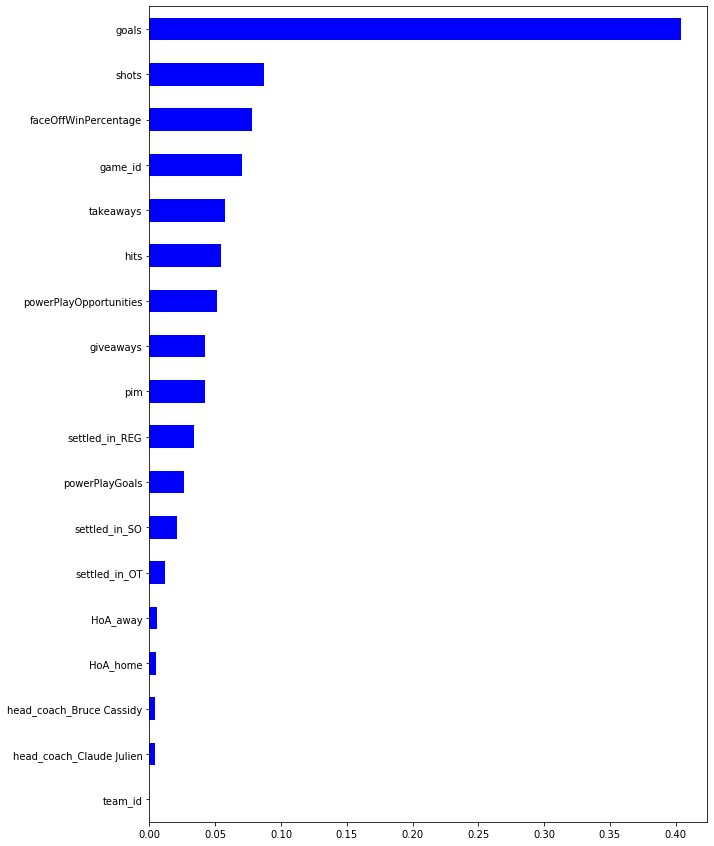

In [30]:
#feature importances
model = pipeline.named_steps['randomforestclassifier']
encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(10,15))
importances.sort_values().plot.barh(color='blue');

In [0]:
#with XG Boost
